## Develop GANs Using Keras

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
import numpy as np
from tensorflow.keras.datasets import mnist
import warnings

# Suppress all Python warnings
warnings.filterwarnings('ignore')

# Load the MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# Normalize the pixel values to the range [-1, 1]
x_train = x_train.astype('float32') / 127.5 - 1.
x_train = np.expand_dims(x_train, axis=-1)

# Print the shape of the data
print(x_train.shape)


(60000, 28, 28, 1)


랜덤 noise (100차원)
    ↓
Dense + LeakyReLU + BatchNorm (256)
    ↓
Dense + LeakyReLU + BatchNorm (512)
    ↓
Dense + LeakyReLU + BatchNorm (1024)
    ↓
Dense(784) + tanh
    ↓
Reshape (28, 28, 1)
    ↓
이미지 한 장 생성!

In [3]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape 

# Define the generator model 
def build_generator(): 
    model = Sequential() 
    model.add(Dense(256, input_dim=100)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(512)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(1024)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(28 * 28 * 1, activation='tanh')) 
    model.add(Reshape((28, 28, 1))) 
    return model 

# Build the generator 
generator = build_generator() 
generator.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [4]:
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LeakyReLU

# Define the discriminator model 
def build_discriminator(): 
    model = Sequential() 
    model.add(Flatten(input_shape=(28, 28, 1))) 
    model.add(Dense(512)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(256)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(1, activation='sigmoid')) 
    return model 

# Build and compile the discriminator 
discriminator = build_discriminator() 
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.layers import Input 
from tensorflow.keras.models import Model 

# Create the GAN by stacking the generator and the discriminator 
def build_gan(generator, discriminator): 
    discriminator.trainable = False 
    gan_input = Input(shape=(100,)) 
    generated_image = generator(gan_input) 
    gan_output = discriminator(generated_image) 
    gan = Model(gan_input, gan_output) 
    gan.compile(loss='binary_crossentropy', optimizer='adam') 
    return gan 

# Build the GAN 
gan = build_gan(generator, discriminator) 
gan.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 28, 28, 1)      │     1,493,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │       533,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,027,025 (7.73 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 537,089 (2.05 MB)

In [6]:
# Define and compile the discriminator model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Flatten

def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Build and recompile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Training parameters 

batch_size = 64 
epochs = 50
sample_interval = 10

# Adversarial ground truths 
real = np.ones((batch_size, 1)) 
fake = np.zeros((batch_size, 1)) 

# Training loop 
for epoch in range(epochs): 
    # Train the discriminator 
    idx = np.random.randint(0, x_train.shape[0], batch_size) 
    real_images = x_train[idx] 
    noise = np.random.normal(0, 1, (batch_size, 100)) 
    generated_images = generator.predict(noise) 
    d_loss_real = discriminator.train_on_batch(real_images, real) 
    d_loss_fake = discriminator.train_on_batch(generated_images, fake) 
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

    # Train the generator 
    noise = np.random.normal(0, 1, (batch_size, 100)) 
    g_loss = gan.train_on_batch(noise, real) 

    # Print the progress 
    if epoch % sample_interval == 0: 
        print(f"{epoch} [D loss: {d_loss[0]}] [D accuracy: {100 * d_loss[1]}%] [G loss: {g_loss}]")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
0 [D loss: 1.0024380683898926] [D accuracy: 7.421875%] [G loss: 0.4519076943397522]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10 [D loss: 0.20366054773330688] [D accuracy: 88.51123046875%] [G loss: 0.14616407454013824]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
20 [D loss: 0.1059186384

### Assessing the Quality of Generated Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


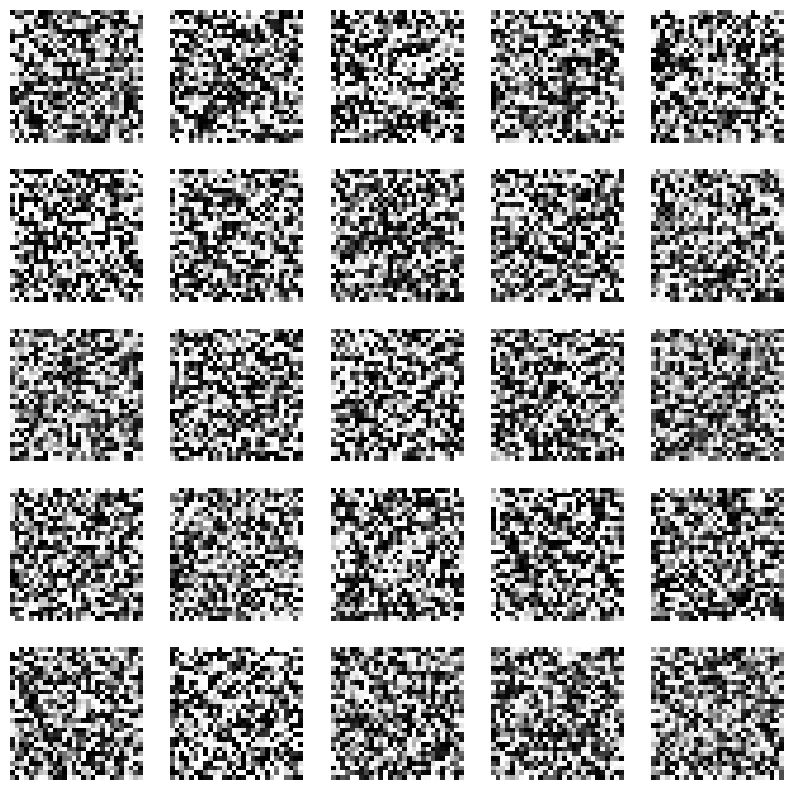

In [8]:
import matplotlib.pyplot as plt 

def sample_images(generator, epoch, num_images=25): 
    noise = np.random.normal(0, 1, (num_images, 100)) 
    generated_images = generator.predict(noise) 
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1] 
    fig, axs = plt.subplots(5, 5, figsize=(10, 10)) 
    count = 0 

    for i in range(5): 
        for j in range(5): 
            axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray') 
            axs[i, j].axis('off') 
            count += 1 
    plt.show() 

# Sample images at the end of training 
sample_images(generator, epochs)


In [9]:
# Calculate and print the discriminator accuracy on real vs. fake images
noise = np.random.normal(0, 1, (batch_size, 100))
generated_images = generator.predict(noise)

# Evaluate the discriminator on real images
real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
d_loss_real = discriminator.evaluate(real_images, np.ones((batch_size, 1)), verbose=0)

# Evaluate the discriminator on fake images
d_loss_fake = discriminator.evaluate(generated_images, np.zeros((batch_size, 1)), verbose=0)

print(f"Discriminator Accuracy on Real Images: {d_loss_real[1] * 100:.2f}%")
print(f"Discriminator Accuracy on Fake Images: {d_loss_fake[1] * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Discriminator Accuracy on Real Images: 100.00%
Discriminator Accuracy on Fake Images: 100.00%


| Situation                          | Meaning                                                                 |
|-----------------------------------|-------------------------------------------------------------------------|
| Both Accuracy ≈ 50%               | Discriminator and Generator are balanced (ideal situation)             |
| Real ≈ 100%, Fake ≈ 100%          | Discriminator is too strong → Generator is still weak                  |
| Real ≈ 50%, Fake ≈ 0%             | Discriminator is weak or Generator is performing very well             |
| Real high, Fake low or vice versa | Imbalance between the two → GAN training might be unstable             |


#### Modify the generator’s architecture
1. Add one more Dense layer with 2048 units to the generator model. 
2. Rebuild the generator and print the summary. 

In [10]:
# Modify the generator model by adding an additional Dense layer 

def build_generator(): 
    model = Sequential() 
    model.add(Dense(256, input_dim=100)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(512)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(1024)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(2048))  # New layer added 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(28 * 28 * 1, activation='tanh')) 
    model.add(Reshape((28, 28, 1))) 
    return model 

# Rebuild the generator 
generator = build_generator() 
generator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 784)            │     1,606,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,403,728 (16.80 MB)

 Trainable params: 4,396,048 (16.77 MB)

 Non-trainable params: 7,680 (30.00 KB)

#### Adjust the discriminator’s learning rate 


1. Change the learning rate of the Adam optimizer for the discriminator to 0.0002. 
2. Rebuild and compile the discriminator with the new learning rate. 

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU

def build_discriminator(): 
    model = Sequential() 
    model.add(Flatten(input_shape=(28, 28, 1))) 
    model.add(Dense(512)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(256)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(1, activation='sigmoid')) 
    return model 

# Rebuild and compile the discriminator with a lower learning rate 
discriminator = build_discriminator() 
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), 
                      metrics=['accuracy']) 

discriminator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

#### Exercise 3 - Visualize training progress 

1. Modify the training loop to store the discriminator and generator losses. 
2. Plot the losses after training to visualize the training progress. 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 
0 [D loss: 0.7163344621658325] [D accuracy: 37.890625] [G loss: 0.03594326600432396]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
10 [D loss: 0.28453513979911804] [D accuracy: 88.80208587646484] [G loss: 0.030367573723196983]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
20 [D loss: 0.17545

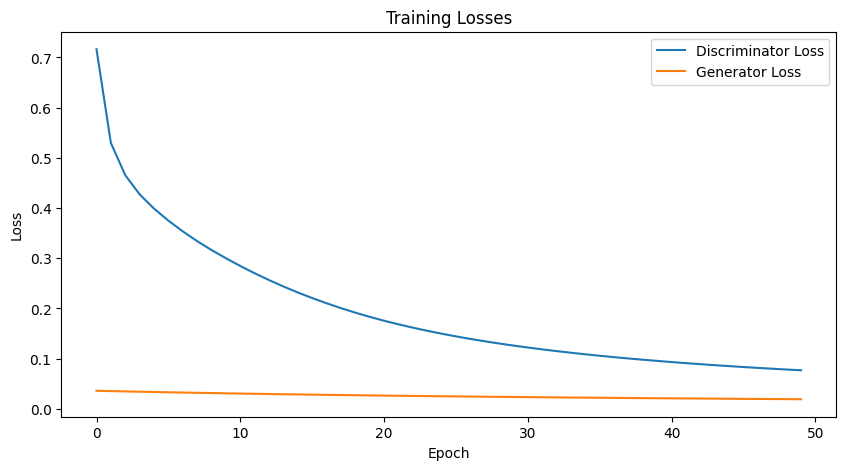

In [12]:
# Initialize lists to store losses 
d_losses = [] 
g_losses = [] 

 
# Training loop with loss storage 
for epoch in range(epochs): 
    idx = np.random.randint(0, x_train.shape[0], batch_size) 
    real_images = x_train[idx] 
    noise = np.random.normal(0, 1, (batch_size, 100)) 
    generated_images = generator.predict(noise) 
    d_loss_real = discriminator.train_on_batch(real_images, real) 
    d_loss_fake = discriminator.train_on_batch(generated_images, fake) 
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
    d_losses.append(d_loss[0]) 
  

    noise = np.random.normal(0, 1, (batch_size, 100)) 
    g_loss = gan.train_on_batch(noise, real) 
    g_losses.append(g_loss) 

  
    if epoch % sample_interval == 0: 
        print(f"{epoch} [D loss: {d_loss[0]}] [D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]") 
  
# Plot the training losses 
plt.figure(figsize=(10, 5)) 
plt.plot(d_losses, label='Discriminator Loss') 
plt.plot(g_losses, label='Generator Loss') 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.title('Training Losses') 
plt.legend() 
plt.show()

| Cause                                | Explanation                                                                                                   |
|-------------------------------------|---------------------------------------------------------------------------------------------------------------|
| Generator is too weak            | Discriminator easily predicts 0 → loss may seem high, but due to loss clipping, it often stays around 0.3–0.7 |
| Discriminator output fixed low   | D(G(z)) ≈ 0, but loss like log(1 - 0.0001) becomes very small (~0.0001)                                       |
| Discriminator is too strong      | Generator can't receive meaningful gradients to improve                                                       |
| GAN loss is hard to interpret     | Low loss doesn’t always mean good performance → what matters is whether the Generator can fool the Discriminator |
